In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

In [117]:
df = pd.read_excel('Лист в Тестовое задание_DS_ML.xlsx')
df = df.rename(columns={'Изменение ставок  относительно начала депозита': 'Изменение ставок относительно начала депозита'})

display(sum(df.isnull().sum()))
display(df.head())
display(df.describe())

0

,Номер депозита,Номер недели жизни депозита,Изменение ставок относительно начала депозита,Изменение курса относительно начала депозита,Объем пополнения
0,1,1,0.021498,-0.046133,0.000000
1,1,2,0.019605,0.030865,0.743323
2,1,3,0.082847,-0.013099,0.977405
3,1,4,-0.025355,-0.007046,0.772670
4,1,5,-0.109462,-0.109332,0.039289


,Номер депозита,Номер недели жизни депозита,Изменение ставок относительно начала депозита,Изменение курса относительно начала депозита,Объем пополнения
count,500.000000,500.00000,500.000000,500.000000,500.000000
mean,50.500000,3.00000,0.000462,0.001271,0.513122
std,28.894979,1.41563,0.098536,0.102760,0.414394
min,1.000000,1.00000,-0.331099,-0.301667,0.000000
25%,25.750000,2.00000,-0.073146,-0.075134,0.021179
50%,50.500000,3.00000,-0.000226,-0.000178,0.739787
75%,75.250000,4.00000,0.069640,0.070544,0.794217
max,100.000000,5.00000,0.266151,0.286025,1.109165


Добавим признаки "Количество пополнений в прошлом" и "Обьем пополнений в прошлом", логично чем они больше, тем больше шанс что пополнят снова

У меня была мысль добавить в признаки пополнения в предыдущие дни(это звучит как то что может иметь значение), но градиентный бустинг и так справляется максимально хорошо без этого признака

Также если так сделать то остается только 100(80 так как должна быть тестовая выборка) данных для обучения, а это мало

Но я решил сделать два признака так как они более интерпретируемые и проще сделать модели с ним

In [118]:
df['Количество пополнений в прошлом'] = 0
df['Объем пополнений в прошлом'] = 0.0

for index, row in df.iterrows():
    previous_replenishments = df[(df['Номер депозита'] == row['Номер депозита']) & (df['Номер недели жизни депозита'] < row['Номер недели жизни депозита'])]
    df.at[index, 'Количество пополнений в прошлом'] = sum(previous_replenishments['Объем пополнения'] > 0)
    df.at[index, 'Объем пополнений в прошлом'] = previous_replenishments['Объем пополнения'].sum()


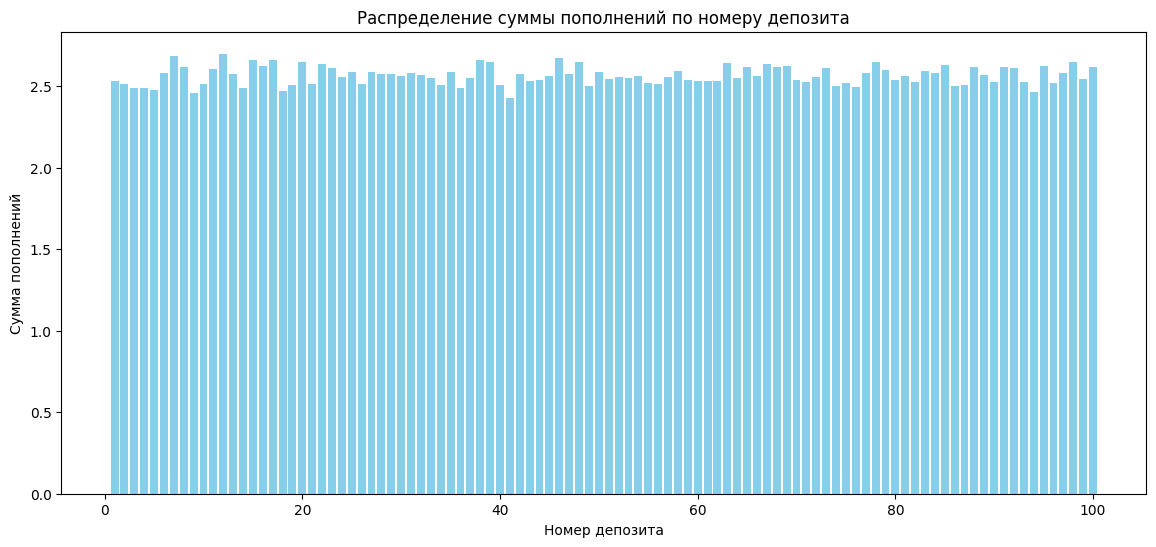

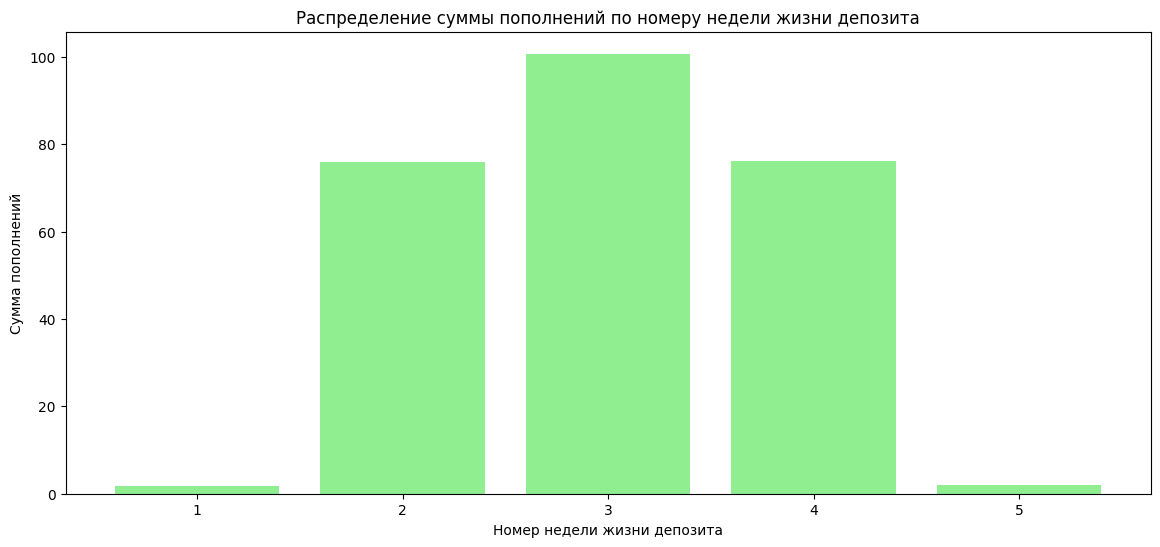

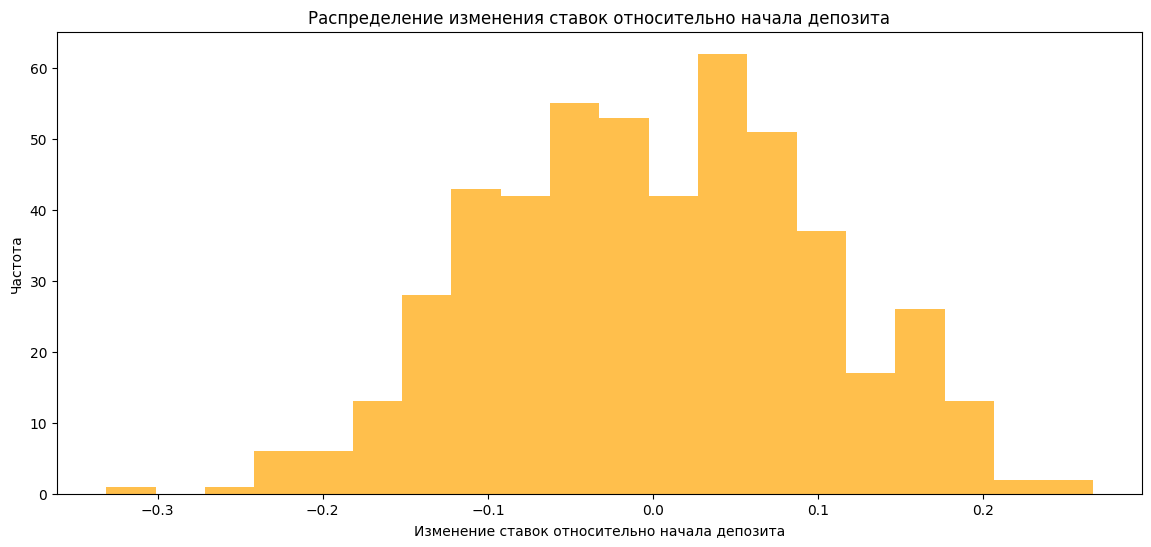

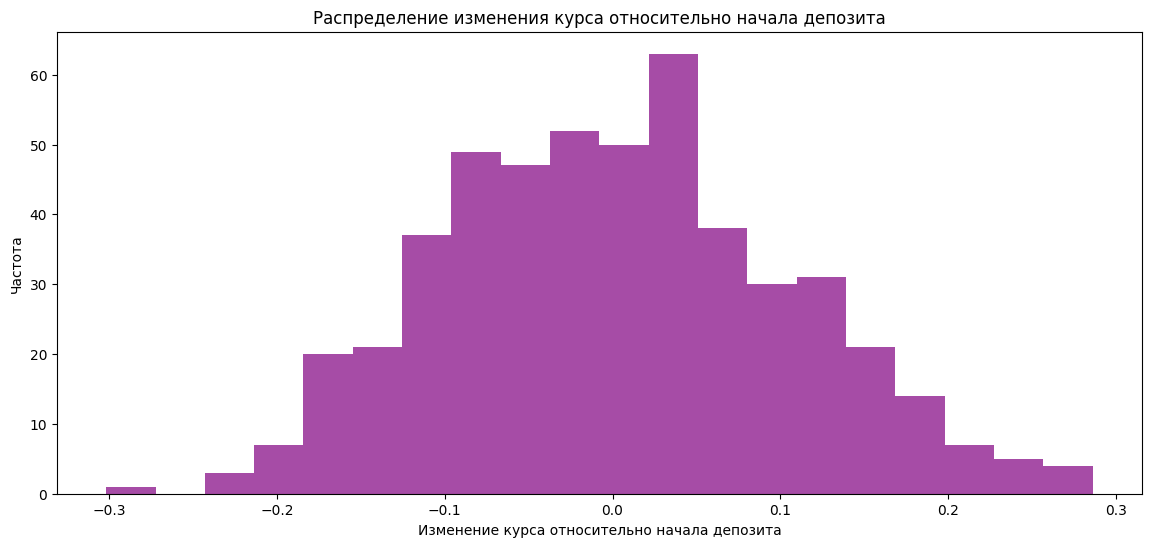

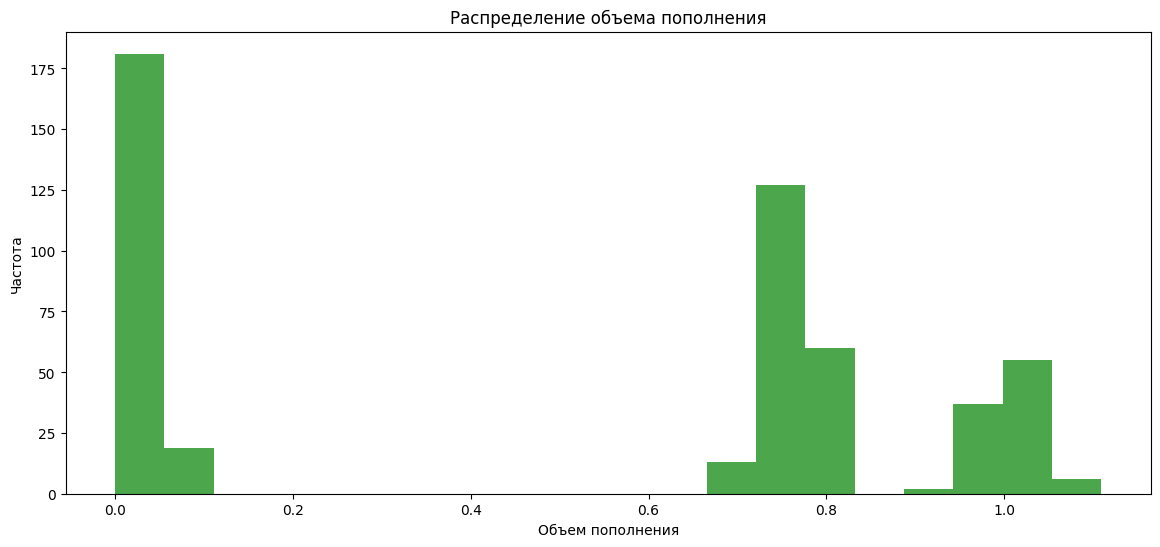

In [119]:
deposit_sum = df.groupby('Номер депозита')['Объем пополнения'].sum().reset_index()

week_sum = df.groupby('Номер недели жизни депозита')['Объем пополнения'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.bar(deposit_sum['Номер депозита'], deposit_sum['Объем пополнения'], color='skyblue')
plt.title('Распределение суммы пополнений по номеру депозита')
plt.xlabel('Номер депозита')
plt.ylabel('Сумма пополнений')
plt.show()

plt.figure(figsize=(14, 6))
plt.bar(week_sum['Номер недели жизни депозита'], week_sum['Объем пополнения'], color='lightgreen')
plt.title('Распределение суммы пополнений по номеру недели жизни депозита')
plt.xlabel('Номер недели жизни депозита')
plt.ylabel('Сумма пополнений')
plt.xticks(week_sum['Номер недели жизни депозита'])
plt.show()

plt.figure(figsize=(14, 6))
plt.hist(df['Изменение ставок относительно начала депозита'], bins=20, color='orange', alpha=0.7)
plt.title('Распределение изменения ставок относительно начала депозита')
plt.xlabel('Изменение ставок относительно начала депозита')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(14, 6))
plt.hist(df['Изменение курса относительно начала депозита'], bins=20, color='purple', alpha=0.7)
plt.title('Распределение изменения курса относительно начала депозита')
plt.xlabel('Изменение курса относительно начала депозита')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(14, 6))
plt.hist(df['Объем пополнения'], bins=20, color='green', alpha=0.7)
plt.title('Распределение объема пополнения')
plt.xlabel('Объем пополнения')
plt.ylabel('Частота')
plt.show()


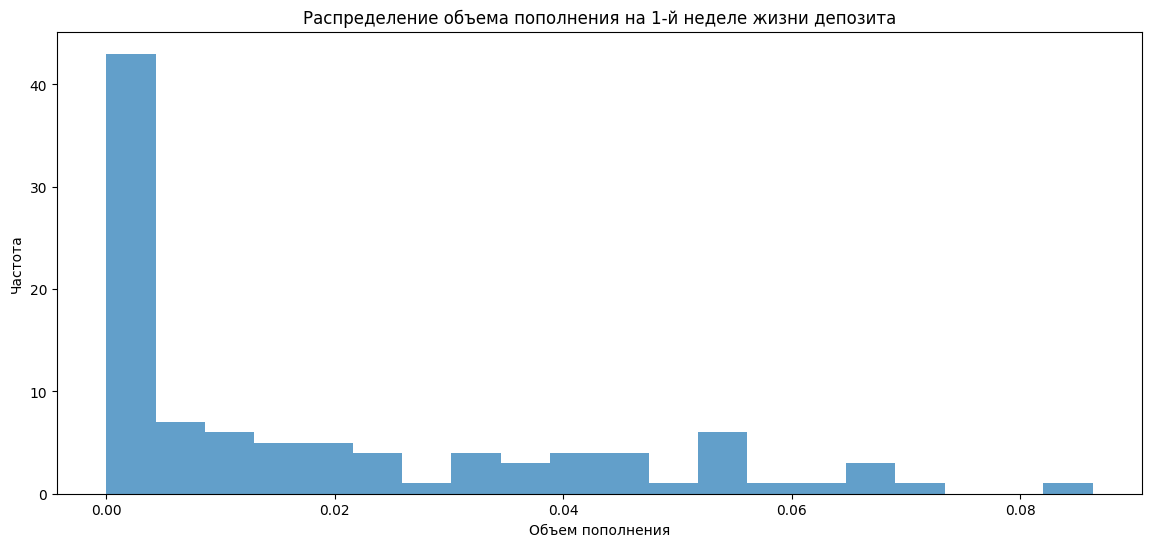

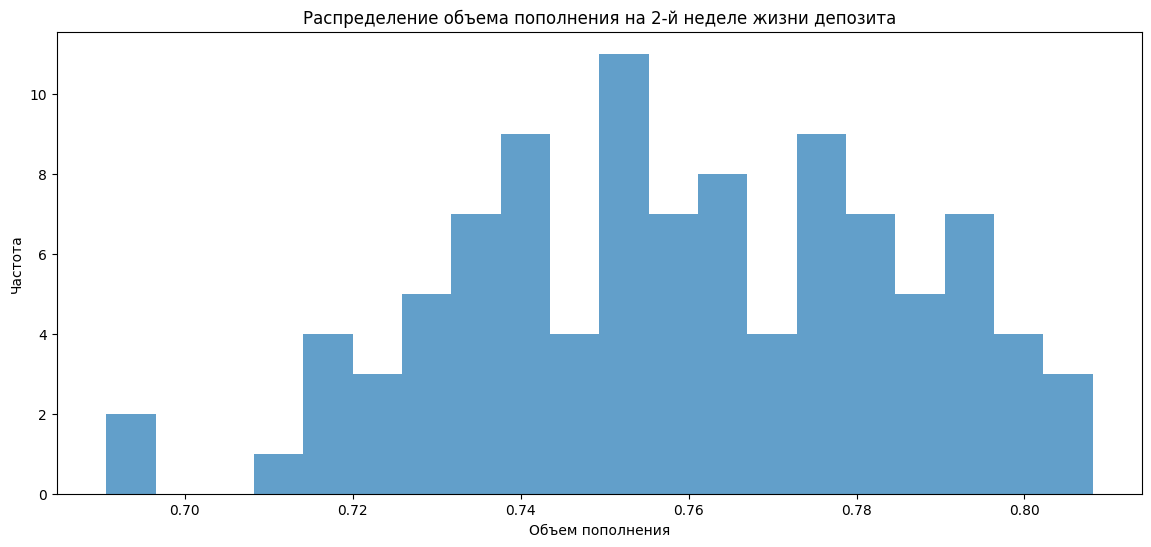

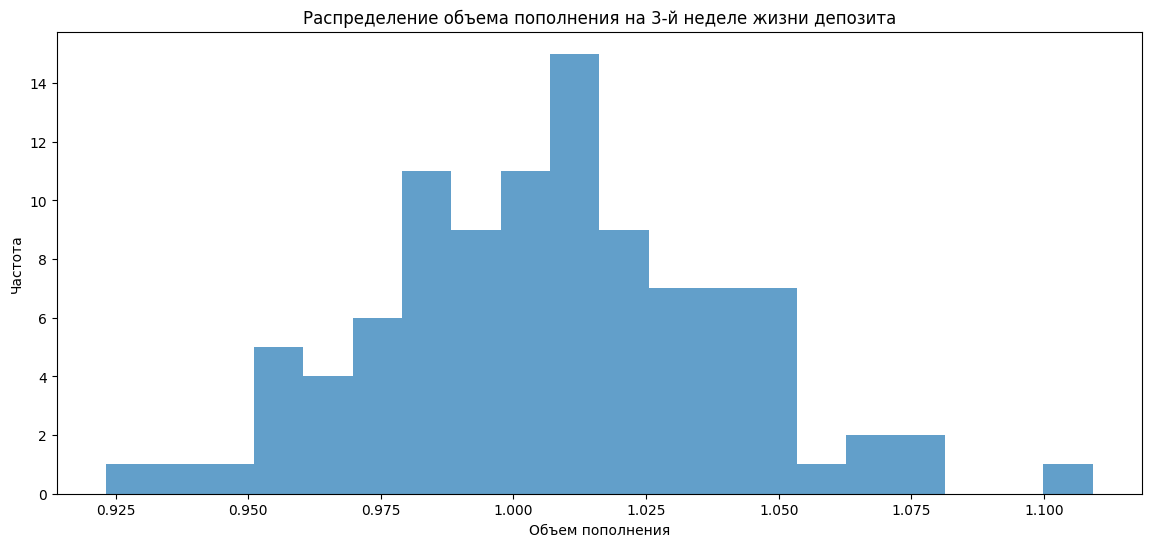

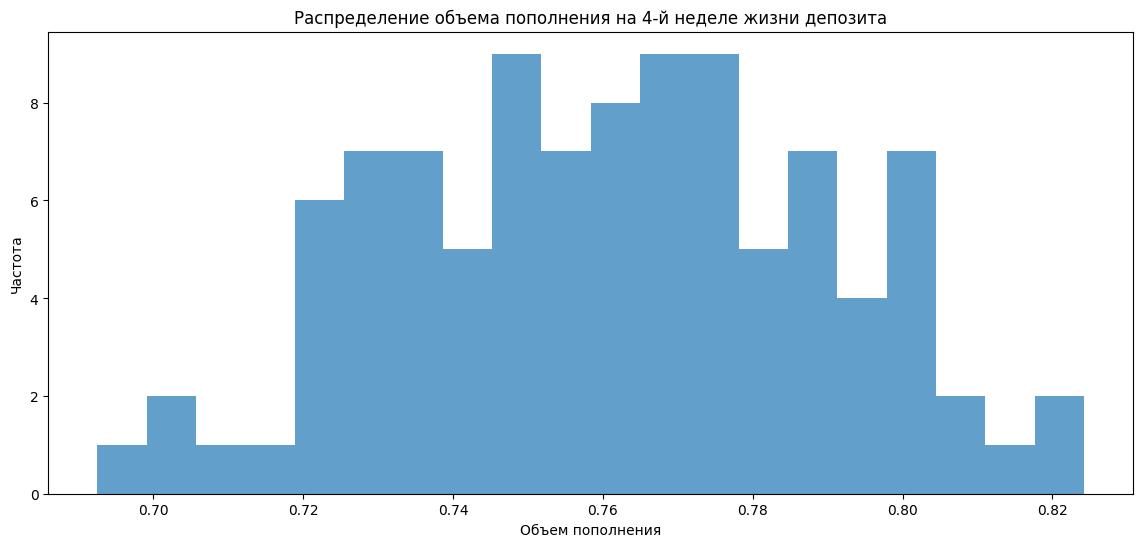

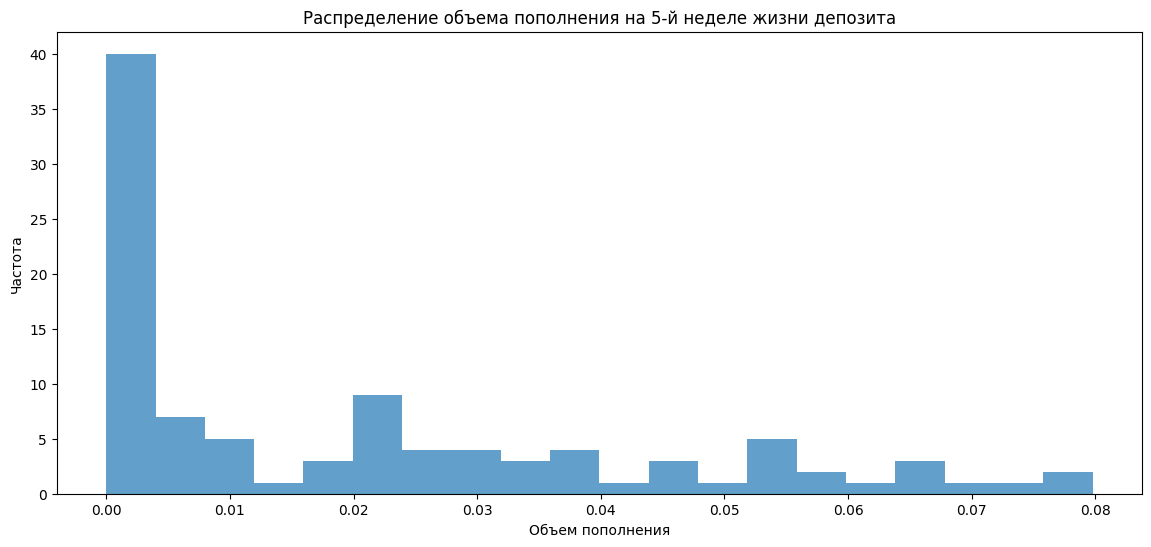

In [120]:
for week in range(1, 6):
    week_data = df[df['Номер недели жизни депозита'] == week]

    plt.figure(figsize=(14, 6))
    plt.hist(week_data['Объем пополнения'], bins=20, alpha=0.7)
    plt.title(f'Распределение объема пополнения на {week}-й неделе жизни депозита')
    plt.xlabel('Объем пополнения')
    plt.ylabel('Частота')
    plt.show()

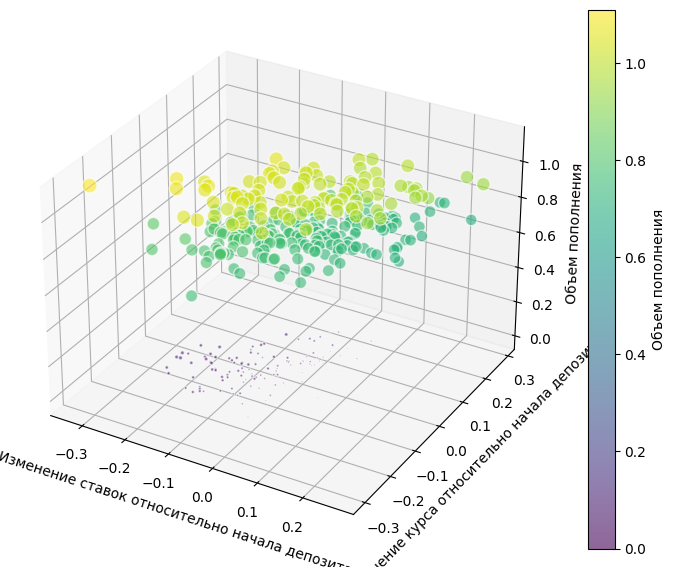

In [121]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sizes = df['Объем пополнения'] * 100  # Увеличиваем размер для лучшей визуализации

scatter = ax.scatter(df['Изменение ставок относительно начала депозита'],
                     df['Изменение курса относительно начала депозита'],
                     df['Объем пополнения'],
                     s=sizes,  # размер точек
                     c=df['Объем пополнения'],  # цвет точек в соответствии с объемом пополнения
                     cmap='viridis', alpha=0.6, edgecolor='w')

ax.set_xlabel('Изменение ставок относительно начала депозита')
ax.set_ylabel('Изменение курса относительно начала депозита')
ax.set_zlabel('Объем пополнения')

fig.colorbar(scatter, ax=ax, label='Объем пополнения')

plt.show()

Видим, что есть три четких кластера в данных

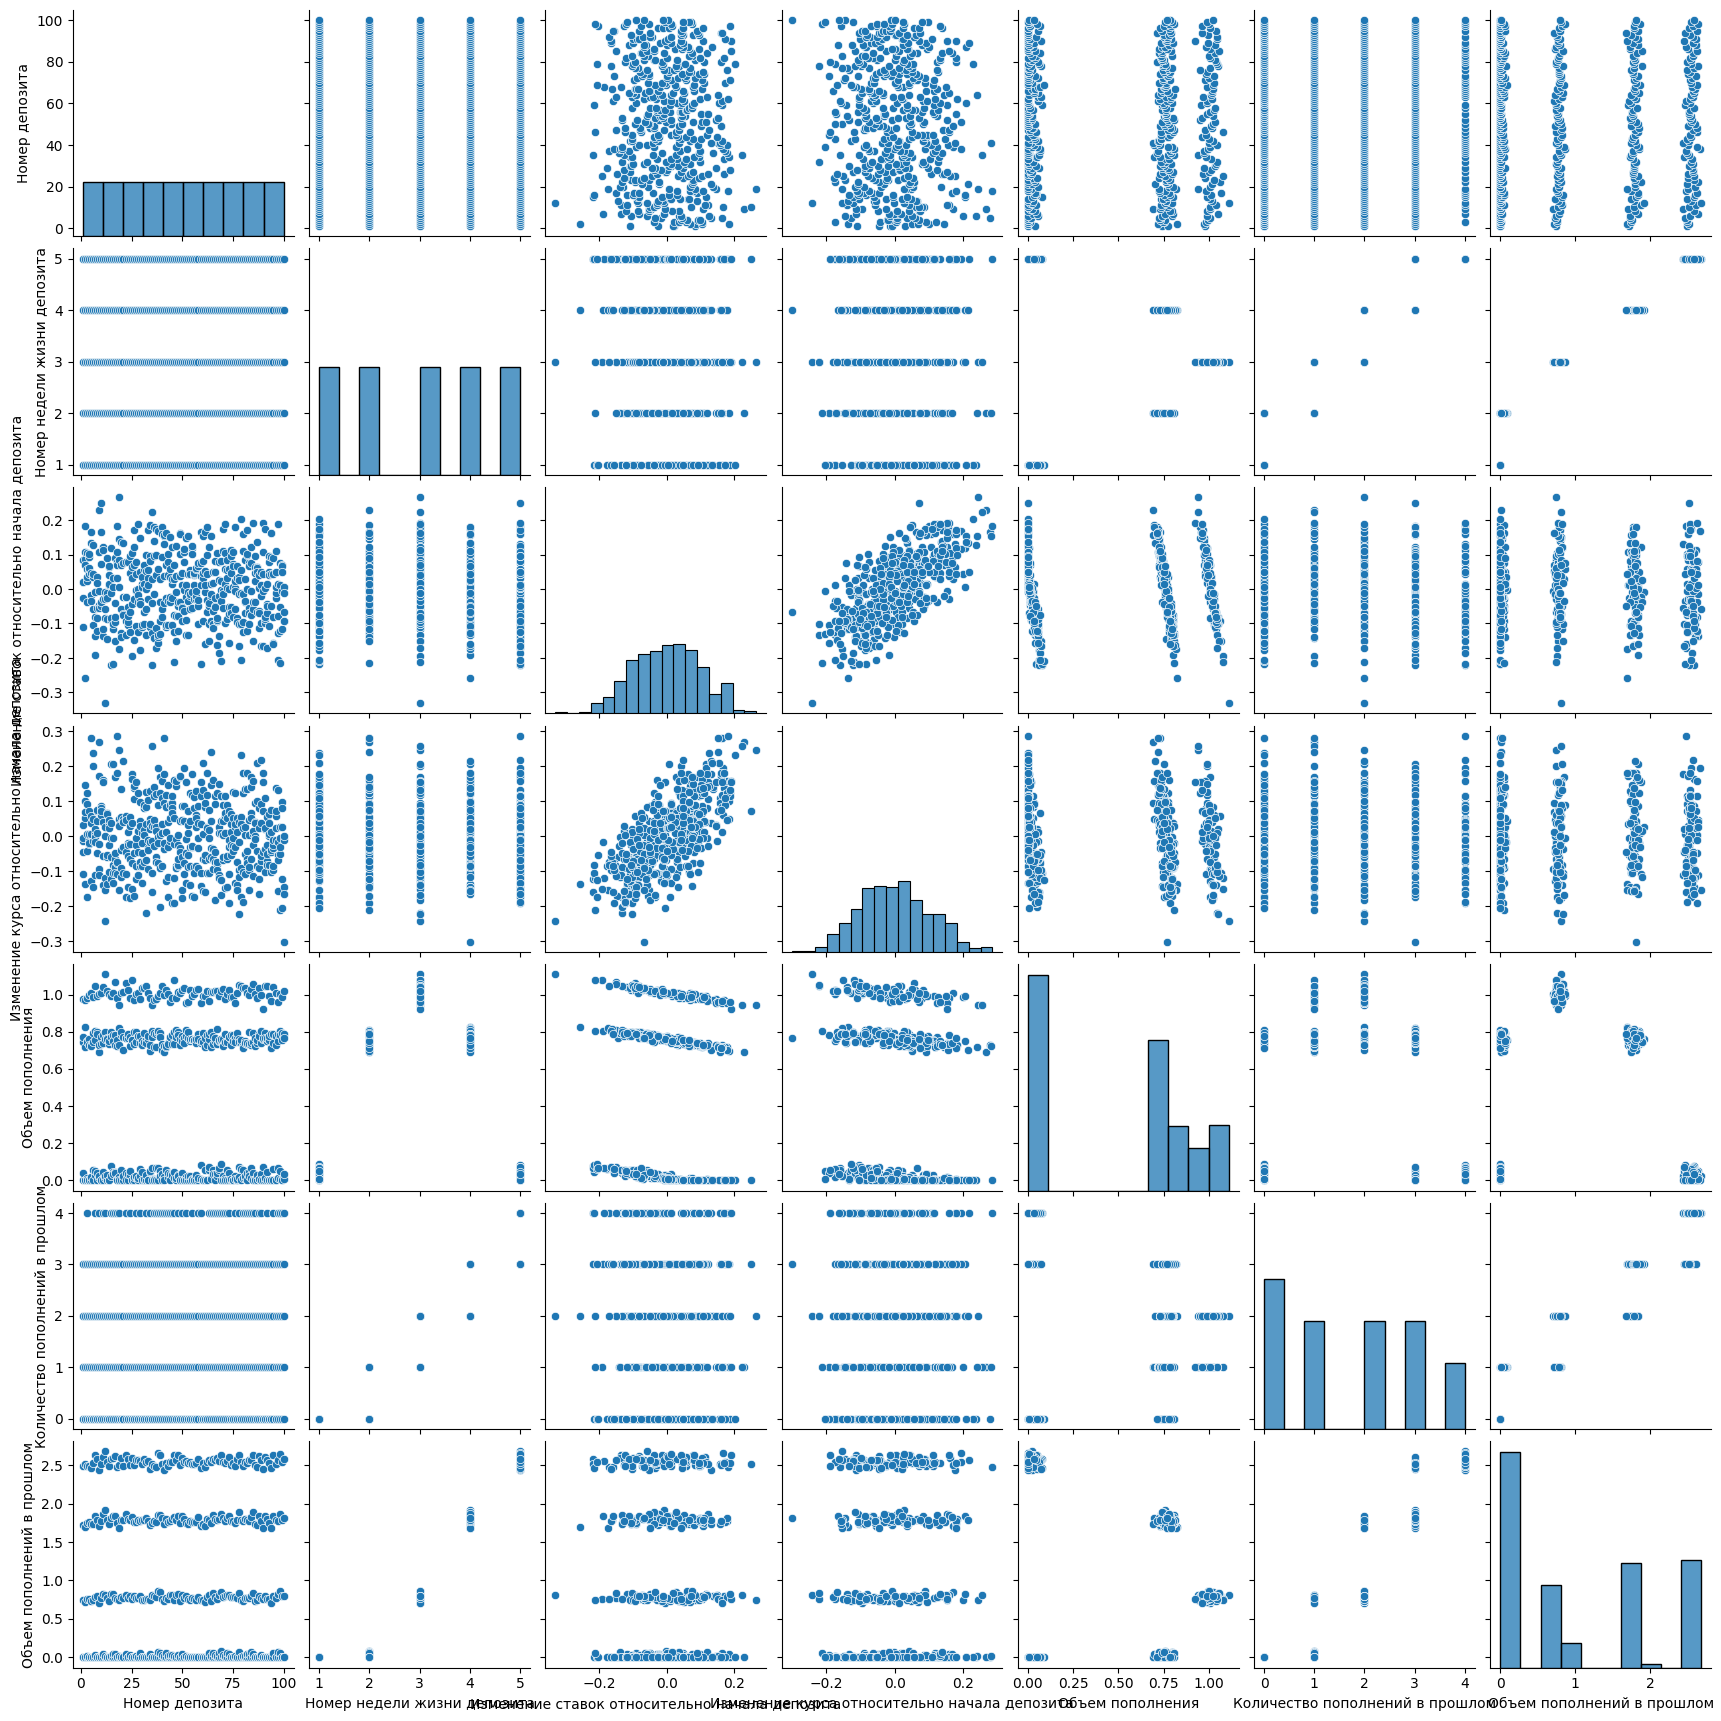

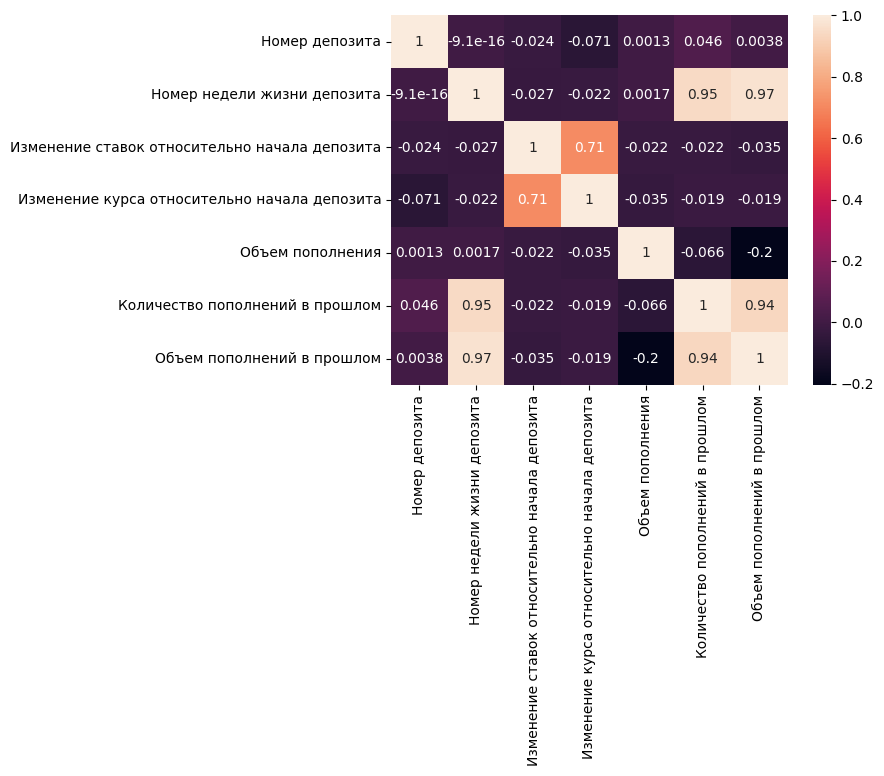

In [122]:
sns.pairplot(df)
plt.show()

corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

Аргументация выбранных факторов
Включение в модель:

Номер недели жизни депозита: Этот параметр критически важен, так как может отражать динамику изменения объема пополнения во времени. Различные недели могут иметь разную статистику пополнений из-за множества факторов (например, изменение экономической ситуации, каникулы и т.д.).

Изменение ставок относительно начала депозита: Это изменение может напрямую влиять на принятие решений клиентами о пополнении депозитов, так как изменение ставок может делать депозит более или менее привлекательным для пополнения.

Изменение курса относительно начала депозита: Аналогично изменению ставок, изменение курса может влиять на решения о пополнении, особенно если депозиты и пополнения осуществляются в валюте.

Не включение в модель:

Номер депозита: Этот параметр является уникальным идентификатором и не несет в себе информации, которая могла бы быть полезной для прогнозирования объема пополнения. Это категориальный признак, который не влияет на целевую переменную напрямую.

In [123]:
X = df[['Изменение ставок относительно начала депозита',
        'Изменение курса относительно начала депозита',
        'Количество пополнений в прошлом',
        'Объем пополнений в прошлом',
        'Номер недели жизни депозита']]
y = df['Объем пополнения']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

MSE: 0.056121907446518196
R^2: 0.66938692715458
Средний коэффициент детерминации для линейной регрессии через кросс-валидацию: 0.6715788743611519


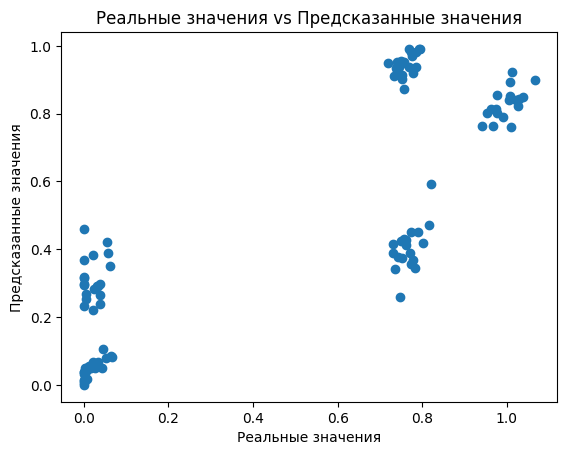

                                               Coefficient
Изменение ставок относительно начала депозита    -0.330412
Изменение курса относительно начала депозита      0.145660
Количество пополнений в прошлом                   0.020022
Объем пополнений в прошлом                       -1.363154
Номер недели жизни депозита                       0.915957


In [124]:
model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print('MSE:', mean_squared_error(y_test, predictions))
print('R^2:', r2_score(y_test, predictions))

scores_lr = cross_val_score(LinearRegression(), X, y, cv=5, scoring='r2')
print("Средний коэффициент детерминации для линейной регрессии через кросс-валидацию:", np.mean(scores_lr))

plt.scatter(y_test, predictions)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные значения vs Предсказанные значения')
plt.show()

coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)

Коэффециент детерминации меньше 0 указывает на то, что модель работает хуже, чем простое предсказание среднего значения зависимой переменной. Такое значение может указывать на то, что модель не подходит для данных или что данные не линейны, а также может указывать на переобучение или недообучение.

MSE (Градиентный Бустинг): 0.00010617221830399299
R^2 (Градиентный Бустинг): 0.9993745415125502
Средний коэффициент детерминации для градиентного бустинга через кросс-валидацию: 0.999213337479269


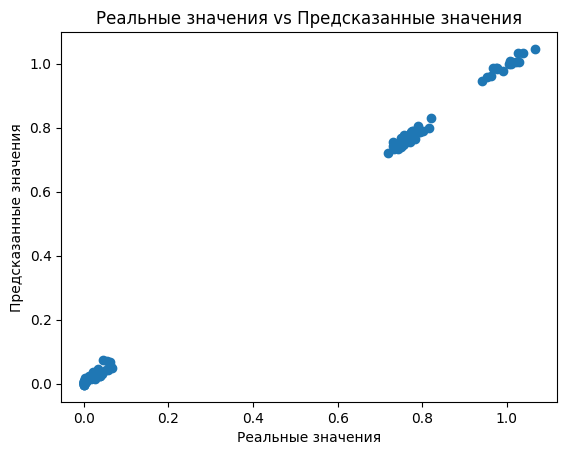

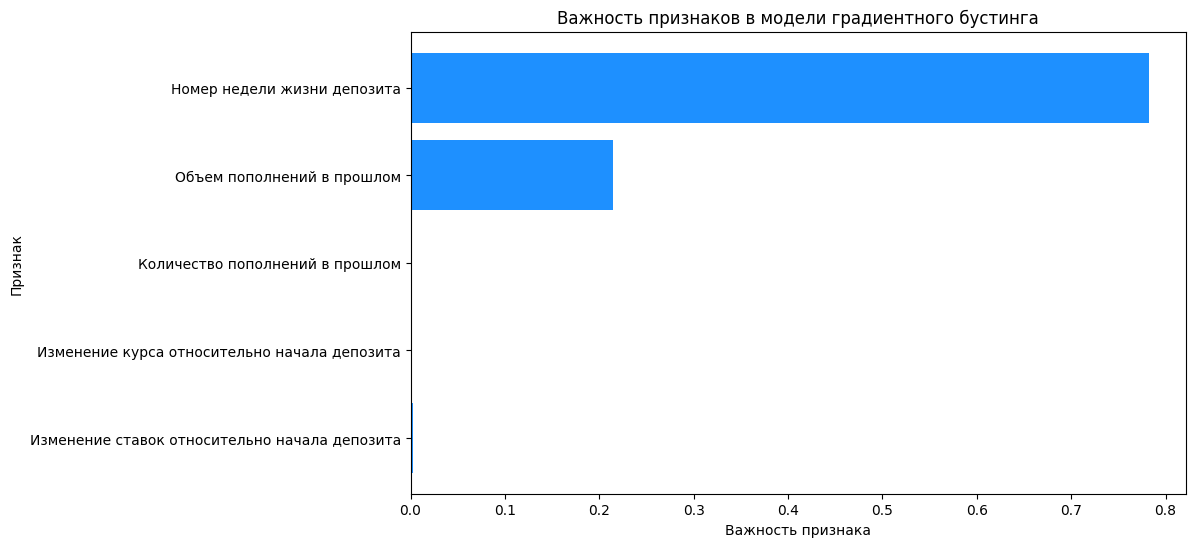

In [125]:
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_reg.fit(X_train, y_train)

predictions_gb = gb_reg.predict(X_test)

print('MSE (Градиентный Бустинг):', mean_squared_error(y_test, predictions_gb))
print('R^2 (Градиентный Бустинг):', r2_score(y_test, predictions_gb))

scores_gb = cross_val_score(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42), X, y, cv=5, scoring='r2')
print("Средний коэффициент детерминации для градиентного бустинга через кросс-валидацию:", np.mean(scores_gb))

plt.scatter(y_test, predictions_gb)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title('Реальные значения vs Предсказанные значения')
plt.show()

feature_importance_gb = gb_reg.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance_gb, color='dodgerblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели градиентного бустинга')
plt.show()

Основной вклад вносит номер недели, остальные признаки дают маленький вклад в качество модели, но дают

MSE с исходными признаками: 0.00010699873711237215

MSE с исходными и новыми признаками: 0.00010617221830399299

MSE только с номером недели: 0.000618104522802229

Коэффециент детерминации составил почти 1 (0.999), что говорит о том, что модель градиентного бустинга практически идеально объясняет вариацию зависимой переменной на разных подвыборках данных. Это может указывать на очень высокую предсказательную способность модели на тренировочных данных.



### Экономическая логика

- **Прогнозирование объема пополнения** помогает банку понять, какие факторы наиболее сильно влияют на решения клиентов о пополнении депозитов. Это важно для адаптации условий депозитных продуктов под текущие тренды и повышения их аттрактивности.
- **Оптимизация ликвидности** и планирование финансовых потоков становятся возможными благодаря точным прогнозам пополнений. Банк может лучше готовиться к возможным изменениям в объемах вкладов и планировать распределение ресурсов.
- **Целевые маркетинговые акции** могут быть разработаны на основе анализа поведения клиентов, что способствует повышению лояльности и удовлетворенности клиентов.

### Ограничения и применимость

1. **Исторические данные:** Модель основана на исторических данных, которые могут не всегда точно отражать будущие тренды, особенно в условиях рыночной волатильности.
2. **Упрощение реальности:** Все модели являются упрощением реальности. В вашей модели используются определенные признаки, которые, хоть и имеют сильное влияние на объем пополнений, могут не учитывать другие важные внешние или внутренние факторы.
3. **Переобучение:** Высокая точность модели, особенно с использованием градиентного бустинга, может свидетельствовать о переобучении, когда модель слишком хорошо адаптируется к тренировочным данным и теряет способность к обобщению.
4. **Применимость в разных условиях:** Модель может показывать разную эффективность в зависимости от экономического контекста, изменения регуляторных требований или поведения рынка.

### Выводы и дальнейшие шаги

- **Тестирование на новых данных:** Важно проверять модель на новых данных, чтобы оценить ее способность к обобщению и адаптации к изменениям во внешней среде.
- **Исследование дополнительных признаков:** Рассмотрение дополнительных переменных, таких как макроэкономические показатели, может улучшить прогностическую способность модели.
- **Оценка рисков и внедрение:** Перед внедрением модели важно оценить потенциальные риски и разработать стратегии их минимизации.